In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
data = pd.read_csv('../Data/housing.csv')

### Extracting required data from the dataset

In [ ]:
data = pd.get_dummies(data, columns=["ocean_proximity"])
data["bedrooms_by_totalrooms"] = data["total_bedrooms"]/data["total_rooms"]
data = data[data["median_house_value"] < 500001] # to remove all capped data
data = data.dropna(subset=["total_bedrooms"])  #dropping all NA values

# Refer EDA notebook for the reasoning behind choosing these features

X = data[["median_income", "ocean_proximity_<1H OCEAN", "ocean_proximity_INLAND", "bedrooms_by_totalrooms"]]
y = data["median_house_value"]
X = X.fillna(X.mean())
y = y.fillna(y.mean())

### Preprocessing

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
means = X_train.mean()
stds = X_train.std()

X_train_scaled = (X_train - means) / stds
X_test_scaled = (X_test - means) / stds
X_train_scaled.head()

,median_income,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,bedrooms_by_totalrooms
5148,-1.606564,1.137598,-0.704397,0.958457
1378,-0.013762,-0.878989,-0.704397,-0.416681
10567,0.282519,1.137598,-0.704397,-0.134610
16253,-0.709042,-0.878989,1.419563,-0.341646
3920,0.319714,1.137598,-0.704397,-0.272353


### Timer decorator

In [4]:
import time
def timer(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        duration = end - start
        if args and hasattr(args[0], '__dict__'):
            setattr(args[0], f'{func.__name__}_time', duration)
        print(f"Function '{func.__name__}' took {duration:.4f} seconds")
        return result
    return wrapper

### Linear Regression Model

In [5]:
class linear_regression:

    def __init__(self, lr=0.01, iters=1000):
        self.lr = lr
        self.iters = iters
        self.weights = None
        self.bias = None
        #convergence variables
        self.converged_iter_mse = None
        self.converged_time_mse = None
        self.converged_iter_mae = None
        self.converged_time_mae = None
        self.converged_iter_rmse = None
        self.converged_time_rmse = None
        self.converged_iter_r2 = None
        self.converged_time_r2 = None
        #history
        self.history = {'mse': [], 'rmse': [], 'mae': [], 'r2': []}

    @timer
    def fit(self,X: pd.DataFrame,y: pd.Series):
        X = X.values
        y = y.values #pylance is stupid

        records, n_features = X.shape

        self.weights = np.zeros(n_features)
        self.bias = 0.0


        #for convergence checking
        prev_mse = float('inf')
        prev_rmse = float('inf')
        prev_mae = float('inf')
        prev_r2 = float('inf')

        t_start = time.perf_counter() # measure time before starting loop

        for iter in range(self.iters):
            y_pred = X.dot(self.weights) + self.bias

            #gradient descent (batch since all the vectors are updated at once)
            dw = (2 / records) * X.T.dot(y_pred - y)
            db = (2 / records) * np.sum(y_pred - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            #error calculation
            mse = np.mean((y - y_pred) ** 2)
            mae  = np.mean(np.abs(y - y_pred))
            rmse = np.sqrt(mse)
            ss_res = np.sum((y - y_pred)**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - ss_res/ss_tot

            #checking if converged
            if self.converged_iter_mse is None and (abs(prev_mse - mse) < 1e-3):
                self.converged_iter_mse = iter
                self.converged_time_mse = time.perf_counter() - t_start
            if self.converged_iter_mae is None and (abs(prev_mae - mae) < 1e-3):
                self.converged_iter_mae = iter
                self.converged_time_mae = time.perf_counter() - t_start
            if self.converged_iter_rmse is None and (abs(prev_rmse - rmse) < 1e-3):
                self.converged_iter_rmse = iter
                self.converged_time_rmse = time.perf_counter() - t_start
            if self.converged_iter_r2 is None and (abs(prev_r2 - r2) < 1e-3):
                self.converged_iter_r2 = iter
                self.converged_time_r2 = time.perf_counter() - t_start

            #updating error metrics
            prev_mse = mse
            prev_mae = mae
            prev_rmse = rmse
            prev_r2 = r2

            # for plotting the errors
            self.history['mse'].append(mse)
            self.history['rmse'].append(rmse)
            self.history['mae'].append(mae)
            self.history['r2'].append(r2)

    def predict(self, X: pd.DataFrame):
        X = X.values # changing to numpy
        return X.dot(self.weights) + self.bias
    
    def r2(self, X: pd.DataFrame, y: pd.Series):
        y_pred = self.predict(X)
        y = y.values
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - ss_res / ss_tot
    
    def mse(self, X: pd.DataFrame, y: pd.Series):
        y_pred = self.predict(X)
        y = y.values
        return np.mean((y - y_pred) ** 2)

    def mae(self, X: pd.DataFrame, y: pd.Series):
        y_pred = self.predict(X)
        y = y.values
        return np.mean(np.abs(y - y_pred))

    def rmse(self, X: pd.DataFrame, y: pd.Series):
        return np.sqrt(self.mse(X, y))
    

In [6]:
model = linear_regression(iters=2000)
model.fit(X_train_scaled,y_train)

Function 'fit' took 0.3740 seconds


In [7]:
print("MSE")
print(f"converged iter : {model.converged_iter_mse}")
print(f"converged time : {model.converged_time_mse}")
print("MAE")
print(f"converged iter : {model.converged_iter_mae}")
print(f"converged time : {model.converged_time_mae}")
print("RMSE")
print(f"converged iter : {model.converged_iter_rmse}")
print(f"converged time : {model.converged_time_rmse}")
print("R2")
print(f"converged iter : {model.converged_iter_r2}")
print(f"converged time : {model.converged_time_r2}")

MSE
converged iter : 1994
converged time : 0.37197532000004685
MAE
converged iter : 1430
converged time : 0.27256066200015994
RMSE
converged iter : 937
converged time : 0.18281208100006552
R2
converged iter : 135
converged time : 0.04147953699998652


In [8]:
model.mse(X_test_scaled,y_test)


np.float64(4075249764.2236986)

In [9]:
model.rmse(X_test_scaled,y_test)


np.float64(63837.68294842552)

In [10]:
model.mae(X_test_scaled,y_test)


np.float64(46669.77144677977)

In [11]:
model.r2(X_test_scaled,y_test)

np.float64(0.5792234047613776)

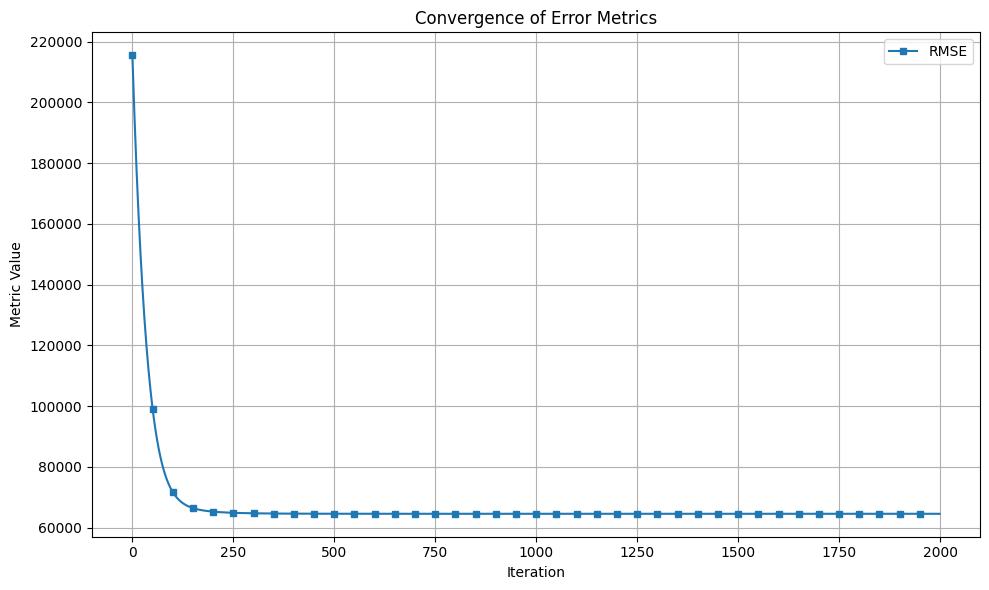

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(model.history['rmse'], label='RMSE', marker='s', markersize=4, markevery=50)
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('Convergence of Error Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

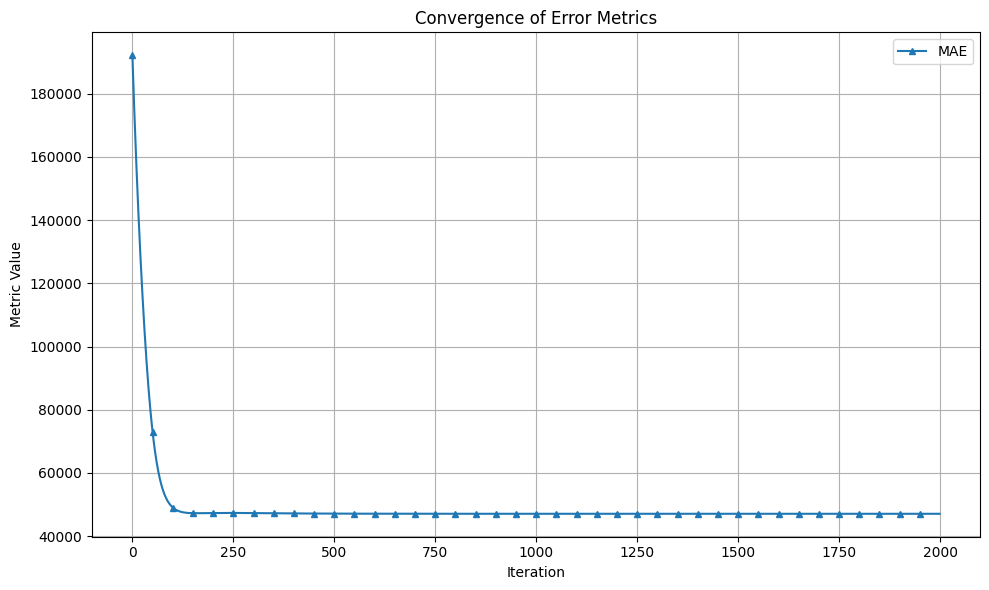

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(model.history['mae'], label='MAE', marker='^', markersize=4, markevery=50)
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('Convergence of Error Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

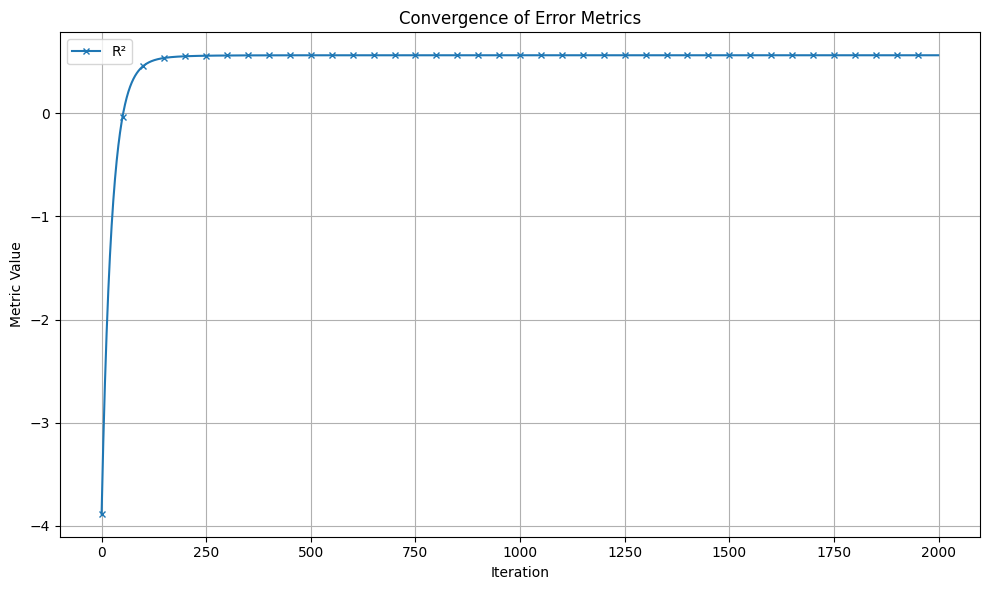

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(model.history['r2'], label='R²', marker='x', markersize=4, markevery=50)
plt.xlabel('Iteration')
plt.ylabel('Metric Value')
plt.title('Convergence of Error Metrics')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()